In [105]:
# %run functions.py

import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import sklearn as skl
from sklearn import linear_model
import csv
from scipy.optimize import minimize_scalar
import plotly.express as px
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from shiny import App, render, ui
from pathlib import Path
from htmltools import css
sns.set_theme()

In [115]:
ui.output_table("underwood")

<div class="shiny-html-output" id="underwood"></div>

In [74]:
hyperparameters = {
    'home_adv': 2.8498763422370907
    , 'decay_rate': 0.0003998040916498869
}

graph_data = get_graph_data(2022, hyperparameters = hyperparameters)


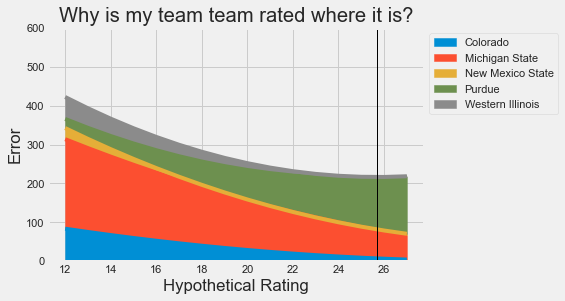

In [75]:
subject = 'Minnesota'

ratings = pd.read_csv("underwood.csv")

data = (graph_data[graph_data['team']==subject]
        .sort_values(by = ['week'], axis=0))
pivoted = data.pivot(index='hypothetical rating', columns='opponent', values=['error'])

pivoted.columns = pivoted.columns.droplevel(0)
pivoted = pivoted.reset_index()
mpl.style.use('fivethirtyeight')
plt = pivoted.plot.area(x='hypothetical rating', ylim = (0, 600), ylabel = 'Error', xlabel = 'Hypothetical Rating', title = 'Why is my team team rated where it is?')
line = ratings[ratings['team']==subject]['rating'].iloc[0]
plt.axvline(x=line, color='black', linewidth = 1)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")

In [116]:
hyperparameters = {
    'home_adv': 2.8498763422370907
    , 'decay_rate': 0.0003998040916498869
}


graph_data = get_graph_data(2022, hyperparameters = hyperparameters)

In [155]:
graph_data

,week,team,opponent,hypothetical rating,error
0,1,Florida Atlantic,Charlotte,-4.0,97.72
1,8,Florida Atlantic,Rice,-4.0,9.41
2,3,Florida Atlantic,Southeastern Louisiana,-4.0,143.61
3,4,Florida Atlantic,Central Florida,-4.0,5.92
4,6,Florida Atlantic,North Texas,-4.0,10.71
...,...,...,...,...,...
17275,6,New Hampshire,Western Michigan,-37.0,1.38
17276,6,New Hampshire,Western Michigan,-36.0,2.44
17277,6,New Hampshire,Western Michigan,-35.0,3.81
17278,6,New Hampshire,Western Michigan,-34.0,5.48


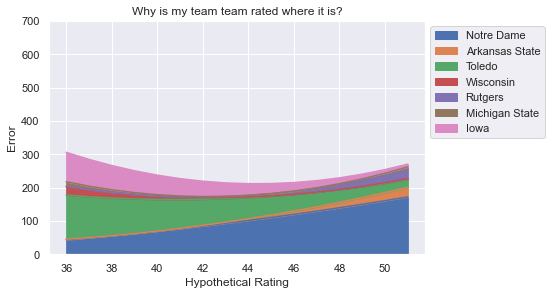

In [187]:
        subject = "Ohio State"

        data = (graph_data[graph_data['team']==subject]
                .sort_values(by = ['week'], axis=0))
        
        cols = (graph_data[graph_data['team']==subject].sort_values(by = ['week'], axis=0))[['week','opponent']].drop_duplicates()['opponent']
        
        pivoted = (data.pivot(index='hypothetical rating', columns='opponent', values=['error'])
                   .reindex(cols, axis=1, level=1))
        
        pivoted.columns = pivoted.columns.droplevel(0)
        pivoted = pivoted.reset_index()
        #mpl.style.use('fivethirtyeight')
        fig = pivoted.plot.area(x='hypothetical rating', ylim = (0, 700), ylabel = 'Error', xlabel = 'Hypothetical Rating', title = 'Why is my team team rated where it is?')
        fig.legend(bbox_to_anchor=(1,1), loc="upper left")

In [186]:
pivoted

opponent,hypothetical rating,Iowa,Michigan State,Rutgers,Wisconsin,Toledo,Arkansas State,Notre Dame
0,36.0,88.29,13.05,1.89,25.06,132.45,1.62,43.50
1,37.0,80.31,10.10,0.88,20.82,122.47,0.69,49.43
2,38.0,72.70,7.52,0.26,16.98,112.87,0.15,55.73
3,39.0,65.47,5.33,0.00,13.53,103.67,0.00,62.41
4,40.0,58.62,3.51,0.13,10.47,94.85,0.25,69.47
5,41.0,52.15,2.07,0.64,7.80,86.43,0.88,76.91
6,42.0,46.06,1.01,1.52,5.53,78.40,1.91,84.73
7,43.0,40.34,0.32,2.79,3.64,70.76,3.33,92.92
8,44.0,35.01,0.02,4.43,2.15,63.51,5.14,101.50
9,45.0,30.05,0.09,6.45,1.05,56.66,7.34,110.45
